In [16]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(style='whitegrid')
import os
import pickle
import math
from scipy.io import loadmat

In [2]:
path = '/media/maousi/Raw/lvad/dnns'

In [3]:
folders = list(filter(
    lambda folder: os.path.isdir(folder),
    map(
        lambda f: os.path.join(path, f),
        os.listdir(path)
    )
))

In [4]:
names = ['Param_LeftVentricle_Emax0', 'Param_LeftVentricle_EmaxRef0',
                      'Param_LeftVentricle_AGain_Emax', 'Param_LeftVentricle_kE']
def read_ys(fp):
    return pd.read_csv(fp, header=None, sep=' ',
                       names=names)

In [5]:
# Data structure: dictionnary:
# - key = dataset folder
# - value = dictionnary:
#      - history -> dictionnary of history (e.g. 'loss' -> list)
#      - ytest -> dataframe
#      - rpm -> list of rpms
data = {}
for f in folders:
    if len(os.listdir(f)) == 0:
        continue
    sub = {}
    with open(os.path.join(f, 'history.bin'), 'rb') as file:
        sub['history'] = pickle.load(file)
    print(f)
    sub['ytest'] = read_ys(os.path.join(f, 'Ytest.txt'))
    sub['ytesthat'] = read_ys(os.path.join(f, 'Ytestpred.txt'))
    data[f] = sub

/media/maousi/Raw/lvad/dnns/dnn_10_layers_128_neurons
/media/maousi/Raw/lvad/dnns/dnn_10_layers_16_neurons
/media/maousi/Raw/lvad/dnns/dnn_10_layers_32_neurons
/media/maousi/Raw/lvad/dnns/dnn_10_layers_64_neurons
/media/maousi/Raw/lvad/dnns/dnn_12_layers_128_neurons
/media/maousi/Raw/lvad/dnns/dnn_12_layers_16_neurons
/media/maousi/Raw/lvad/dnns/dnn_12_layers_32_neurons
/media/maousi/Raw/lvad/dnns/dnn_12_layers_64_neurons
/media/maousi/Raw/lvad/dnns/dnn_6_layers_128_neurons
/media/maousi/Raw/lvad/dnns/dnn_6_layers_256_neurons
/media/maousi/Raw/lvad/dnns/dnn_6_layers_32_neurons
/media/maousi/Raw/lvad/dnns/dnn_6_layers_64_neurons
/media/maousi/Raw/lvad/dnns/dnn_8_layers_128_neurons
/media/maousi/Raw/lvad/dnns/dnn_8_layers_16_neurons
/media/maousi/Raw/lvad/dnns/dnn_8_layers_32_neurons
/media/maousi/Raw/lvad/dnns/dnn_8_layers_64_neurons


In [20]:
norm = loadmat(os.path.join(path, 'normdata.mat'))
rpm_test = norm['Xtest'][:, -1] * (norm['Xmaxs'][:, -1] - norm['Xmins'][:, -1]) + norm['Xmins'][:, -1]
del norm
rpm_test

array([5100., 5700., 5900., ..., 5800., 5100., 4200.])

In [6]:
final_val_loss = [
    (folder, data[folder]['history']['val_loss'][-1]) for folder in data
]
final_val_loss = sorted(final_val_loss, key=lambda e: e[1])
best_sorted = [e[0] for e in final_val_loss]
best_sorted[:5]

['/media/maousi/Raw/lvad/dnns/dnn_6_layers_256_neurons',
 '/media/maousi/Raw/lvad/dnns/dnn_6_layers_64_neurons',
 '/media/maousi/Raw/lvad/dnns/dnn_8_layers_128_neurons',
 '/media/maousi/Raw/lvad/dnns/dnn_6_layers_128_neurons',
 '/media/maousi/Raw/lvad/dnns/dnn_8_layers_64_neurons']

In [8]:
def parse_name(fname):
    ls = fname.split('_')
    return f'L={ls[-4]}, N={ls[-2]}'

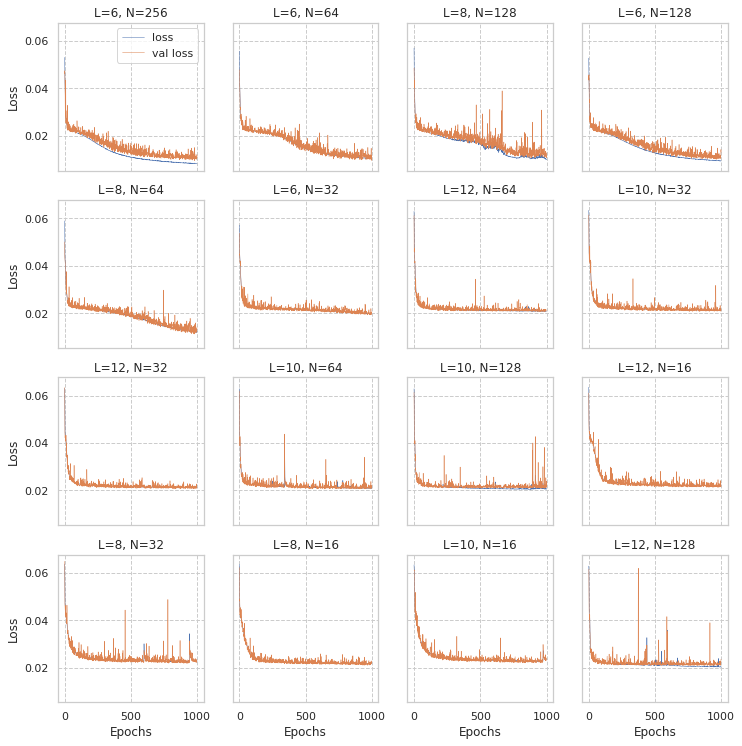

In [9]:
ncol = 4
nrow = math.ceil(len(data) / ncol)
fig, axes = plt.subplots(nrow, ncol, figsize=(12, 3*nrow+.5), sharex=True, sharey=True)

for ax, folder in zip(axes.ravel(), best_sorted):
    ax.plot(data[folder]['history']['loss'], lw=.5, label='loss')
    ax.plot(data[folder]['history']['val_loss'], lw=.5, label='val loss')
    ax.set_title(parse_name(folder))
    ax.grid(ls='--')

axes[0,0].legend()
for a in axes[-1, :]:
    a.set_xlabel('Epochs')
for a in axes[:, 0]:
    a.set_ylabel('Loss')

plt.savefig('figs/dnn_architectures_bis.pdf')

# Exact vs predicted



In [25]:
df = []
for folder in data:
    tmp = folder.split('_')
    layers, neurons = tmp[-4], tmp[-2]
    layers, neurons = folder.split('_')[-4:-1:2]
    tmp = data[folder]['ytest'].join(data[folder]['ytesthat'], rsuffix='_hat')
    tmp['layers'] = int(layers)
    tmp['neurons'] = int(neurons)
    tmp['desc'] = f'{layers} layers, {neurons} neurons'
    tmp['rpm'] = rpm_test
    df.append(tmp)

df = pd.concat(df, ignore_index=True)
df

,Param_LeftVentricle_Emax0,Param_LeftVentricle_EmaxRef0,Param_LeftVentricle_AGain_Emax,Param_LeftVentricle_kE,Param_LeftVentricle_Emax0_hat,Param_LeftVentricle_EmaxRef0_hat,Param_LeftVentricle_AGain_Emax_hat,Param_LeftVentricle_kE_hat,layers,neurons,desc,rpm
0,1.826396,2.360589,0.467659,0.012638,1.935422,2.335003,0.439870,0.013346,10,128,"10 layers, 128 neurons",5100.0
1,2.696736,0.395388,0.397031,0.013295,2.704639,0.424743,0.296173,0.013431,10,128,"10 layers, 128 neurons",5700.0
2,0.568347,2.003394,0.380238,0.011284,0.675504,2.251447,0.382279,0.011409,10,128,"10 layers, 128 neurons",5900.0
3,1.506046,1.658621,0.242821,0.011479,1.496677,1.603435,0.336947,0.011686,10,128,"10 layers, 128 neurons",5800.0
4,2.384774,0.374431,0.459330,0.012726,2.321719,0.558461,0.342032,0.012829,10,128,"10 layers, 128 neurons",5100.0
...,...,...,...,...,...,...,...,...,...,...,...,...
167995,0.317691,1.333223,0.270735,0.013712,0.298857,1.300356,0.307384,0.013857,8,64,"8 layers, 64 neurons",4400.0
167996,0.799416,0.313290,0.257609,0.012913,0.830015,0.256916,0.283789,0.013176,8,64,"8 layers, 64 neurons",4300.0
167997,1.951873,0.266491,0.292459,0.011946,2.064538,0.309196,0.311028,0.011885,8,64,"8 layers, 64 neurons",5800.0
167998,1.437731,0.919122,0.451908,0.011669,1.576154,1.093382,0.358649,0.011862,8,64,"8 layers, 64 neurons",5100.0


In [11]:
for var in names:
    df[var+'_relerr'] = np.abs((df[var] - df[var+'_hat']) / df[var])

In [12]:
dfstats = {}
for desc, subdf in df.groupby('desc'):
    k = list(subdf.layers.unique())
    k.extend(subdf.neurons.unique())
    dfstats[tuple(k)] = {
        var: subdf[var+'_relerr'].mean()
        for var in names
    }

dfstats = pd.DataFrame(dfstats).transpose()
dfstats.index.name = ('layers', 'neurons')
dfstats

Param_LeftVentricle_Emax0  Param_LeftVentricle_EmaxRef0  \
10 128                   0.088002                      0.096525   
   16                    0.150600                      0.096071   
   32                    0.091760                      0.092165   
   64                    0.097735                      0.090512   
12 128                   0.103330                      0.093935   
   16                    0.114240                      0.093295   
   32                    0.093401                      0.095329   
   64                    0.086824                      0.089485   
6  128                   0.133227                      0.087312   
   256                   0.100803                      0.086573   
   32                    0.101995                      0.095155   
   64                    0.094869                      0.079212   
8  128                   0.096378                      0.091324   
   16                    0.160664                      0.090640   
   32                    0.130218                      0.095437   
   64                    0.126838                      0.087719   

        Param_LeftVentricle_AGain_Emax  Param_LeftVentricle_kE  
10 128                        0.211565                0.009477  
   16                         0.215115                0.012341  
   32                         0.211415                0.007980  
   64                         0.211538                0.010202  
12 128                        0.214097                0.019388  
   16                         0.212585                0.009140  
   32                         0.214218                0.007318  
   64                         0.212678                0.008028  
6  128                        0.133391                0.013886  
   256                        0.124949                0.008342  
   32                         0.198934                0.014930  
   64                         0.134084                0.010774  
8  128                        0.147537                0.011635  
   16                         0.212350                0.009397  
   32                         0.214666                0.011248  
   64                         0.149510                0.010569

In [13]:
# Find min-max to setup axes
axes = {
    var: {
        k2: v
        for k2, v in zip(['xmin', 'xmax', 'ymin', 'ymax'],
        [
            min(df[var].min(), df[var+'_hat'].min()),
            max(df[var].max(), df[var+'_hat'].max())
        ] * 2)
    }
    for var in names
}
axes

{'Param_LeftVentricle_Emax0': {'xmin': 0.20013822280711077,
  'xmax': 2.9492989776230267,
  'ymin': 0.20013822280711077,
  'ymax': 2.9492989776230267},
 'Param_LeftVentricle_EmaxRef0': {'xmin': 0.20012652833283334,
  'xmax': 2.391919282341758,
  'ymin': 0.20012652833283334,
  'ymax': 2.391919282341758},
 'Param_LeftVentricle_AGain_Emax': {'xmin': 0.20002167907708596,
  'xmax': 0.4749894322591831,
  'ymin': 0.20002167907708596,
  'ymax': 0.4749894322591831},
 'Param_LeftVentricle_kE': {'xmin': 0.011000074676655022,
  'xmax': 0.01399963246864461,
  'ymin': 0.011000074676655022,
  'ymax': 0.01399963246864461}}

In [14]:
df

,Param_LeftVentricle_Emax0,Param_LeftVentricle_EmaxRef0,Param_LeftVentricle_AGain_Emax,Param_LeftVentricle_kE,Param_LeftVentricle_Emax0_hat,Param_LeftVentricle_EmaxRef0_hat,Param_LeftVentricle_AGain_Emax_hat,Param_LeftVentricle_kE_hat,layers,neurons,desc,Param_LeftVentricle_Emax0_relerr,Param_LeftVentricle_EmaxRef0_relerr,Param_LeftVentricle_AGain_Emax_relerr,Param_LeftVentricle_kE_relerr
0,1.826396,2.360589,0.467659,0.012638,1.935422,2.335003,0.439870,0.013346,10,128,"10 layers, 128 neurons",0.059695,0.010839,0.059420,0.056031
1,2.696736,0.395388,0.397031,0.013295,2.704639,0.424743,0.296173,0.013431,10,128,"10 layers, 128 neurons",0.002931,0.074244,0.254029,0.010216
2,0.568347,2.003394,0.380238,0.011284,0.675504,2.251447,0.382279,0.011409,10,128,"10 layers, 128 neurons",0.188542,0.123817,0.005367,0.011113
3,1.506046,1.658621,0.242821,0.011479,1.496677,1.603435,0.336947,0.011686,10,128,"10 layers, 128 neurons",0.006221,0.033272,0.387640,0.018040
4,2.384774,0.374431,0.459330,0.012726,2.321719,0.558461,0.342032,0.012829,10,128,"10 layers, 128 neurons",0.026441,0.491493,0.255369,0.008119
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167995,0.317691,1.333223,0.270735,0.013712,0.298857,1.300356,0.307384,0.013857,8,64,"8 layers, 64 neurons",0.059285,0.024652,0.135368,0.010617
167996,0.799416,0.313290,0.257609,0.012913,0.830015,0.256916,0.283789,0.013176,8,64,"8 layers, 64 neurons",0.038276,0.179941,0.101627,0.020378
167997,1.951873,0.266491,0.292459,0.011946,2.064538,0.309196,0.311028,0.011885,8,64,"8 layers, 64 neurons",0.057721,0.160247,0.063492,0.005090
167998,1.437731,0.919122,0.451908,0.011669,1.576154,1.093382,0.358649,0.011862,8,64,"8 layers, 64 neurons",0.096279,0.189594,0.206368,0.016530


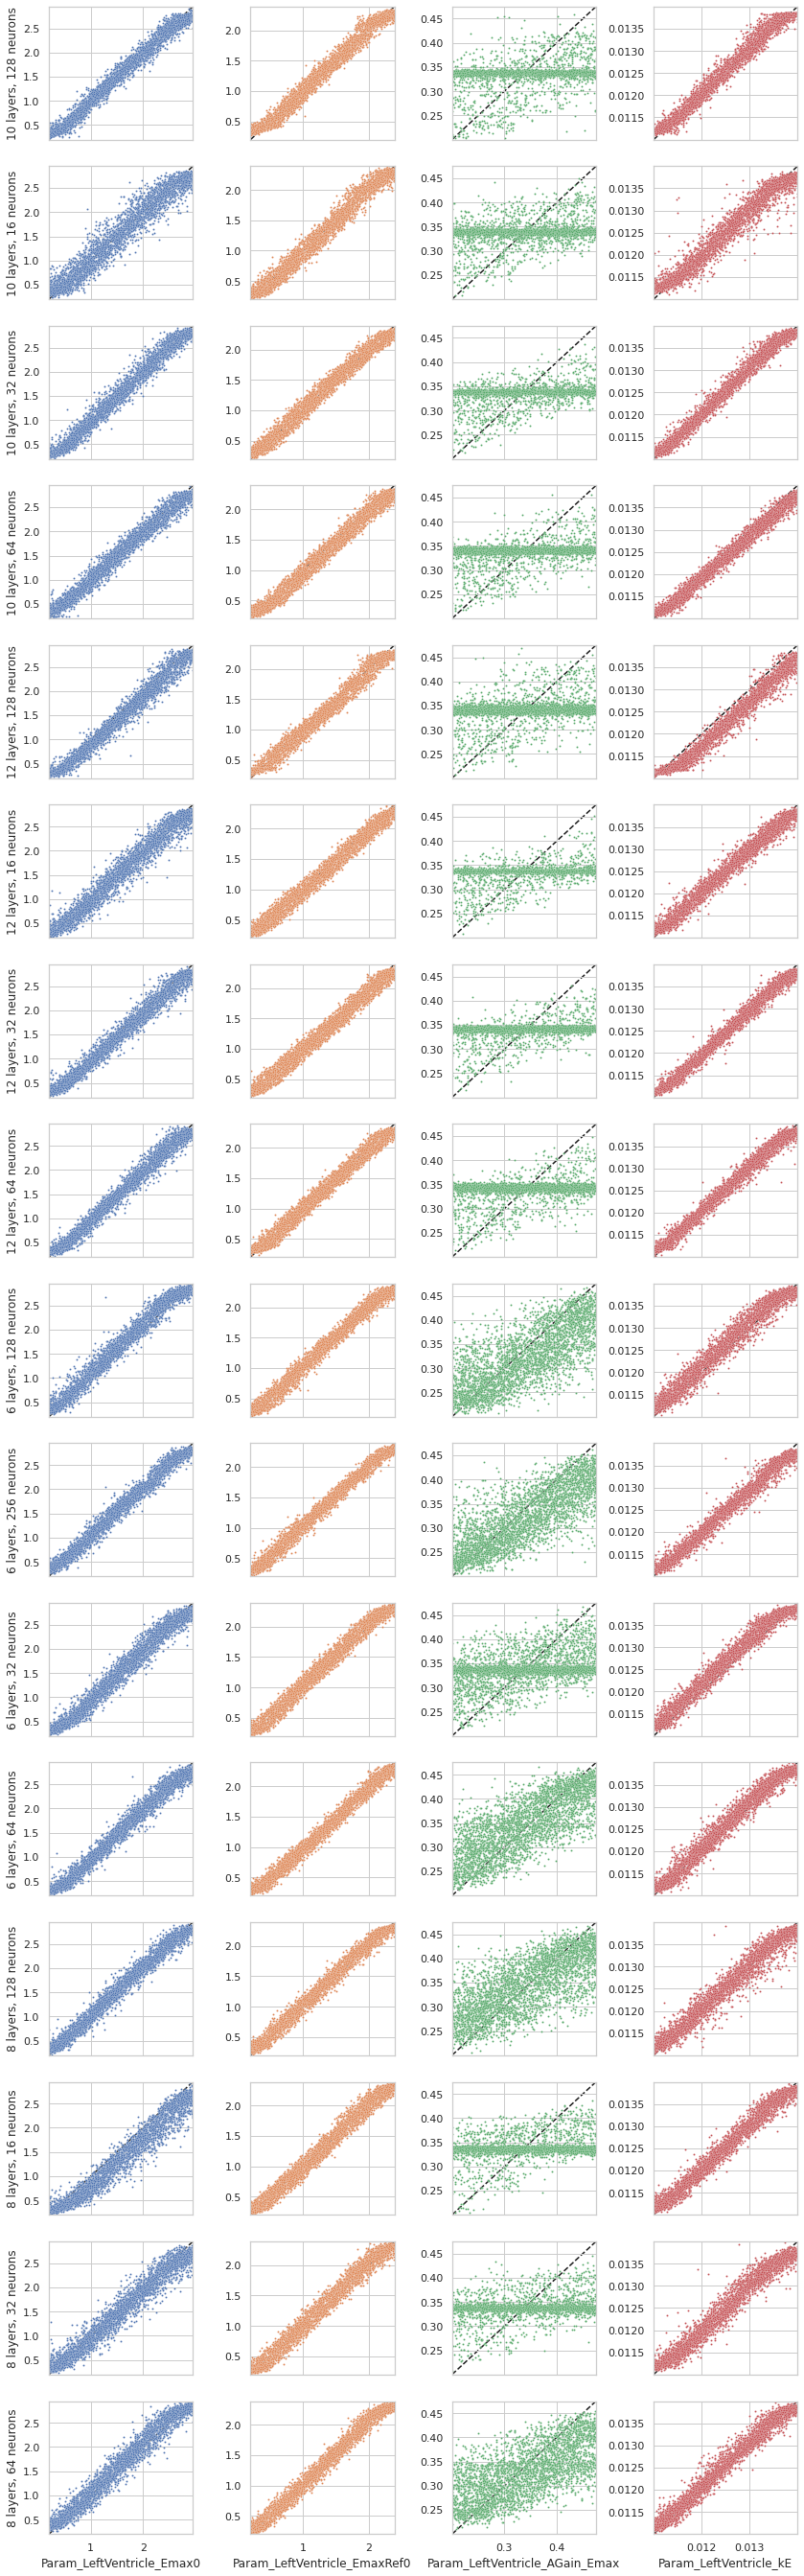

In [15]:
configs = df['desc'].unique()

fig, ax = plt.subplots(len(configs), 4, figsize=(14, len(configs)*3 + .5),
                       sharex='col', sharey='col')
colors = sns.color_palette(n_colors=4)

for i, config in enumerate(configs):
    for j, (var, a) in enumerate(zip(names, ax[i])):
        sns.scatterplot(data=df[df.desc == config].sample(frac=.3), x=var, y=f'{var}_hat', ax=a, color=colors[j], s=4)
        a.set_ylabel('')
        a.axis(**axes[var])
        a.plot([axes[var]['xmin'],axes[var]['xmax']], [axes[var]['ymin'], axes[var]['ymax']], '--k', zorder=0)

for conf, a in zip(configs, ax[:, 0]):
    a.set_ylabel(conf.replace('_', ' '))
    
plt.subplots_adjust(wspace=.4)
#plt.tight_layout()
plt.savefig('figs/dnn_comparison.pdf')

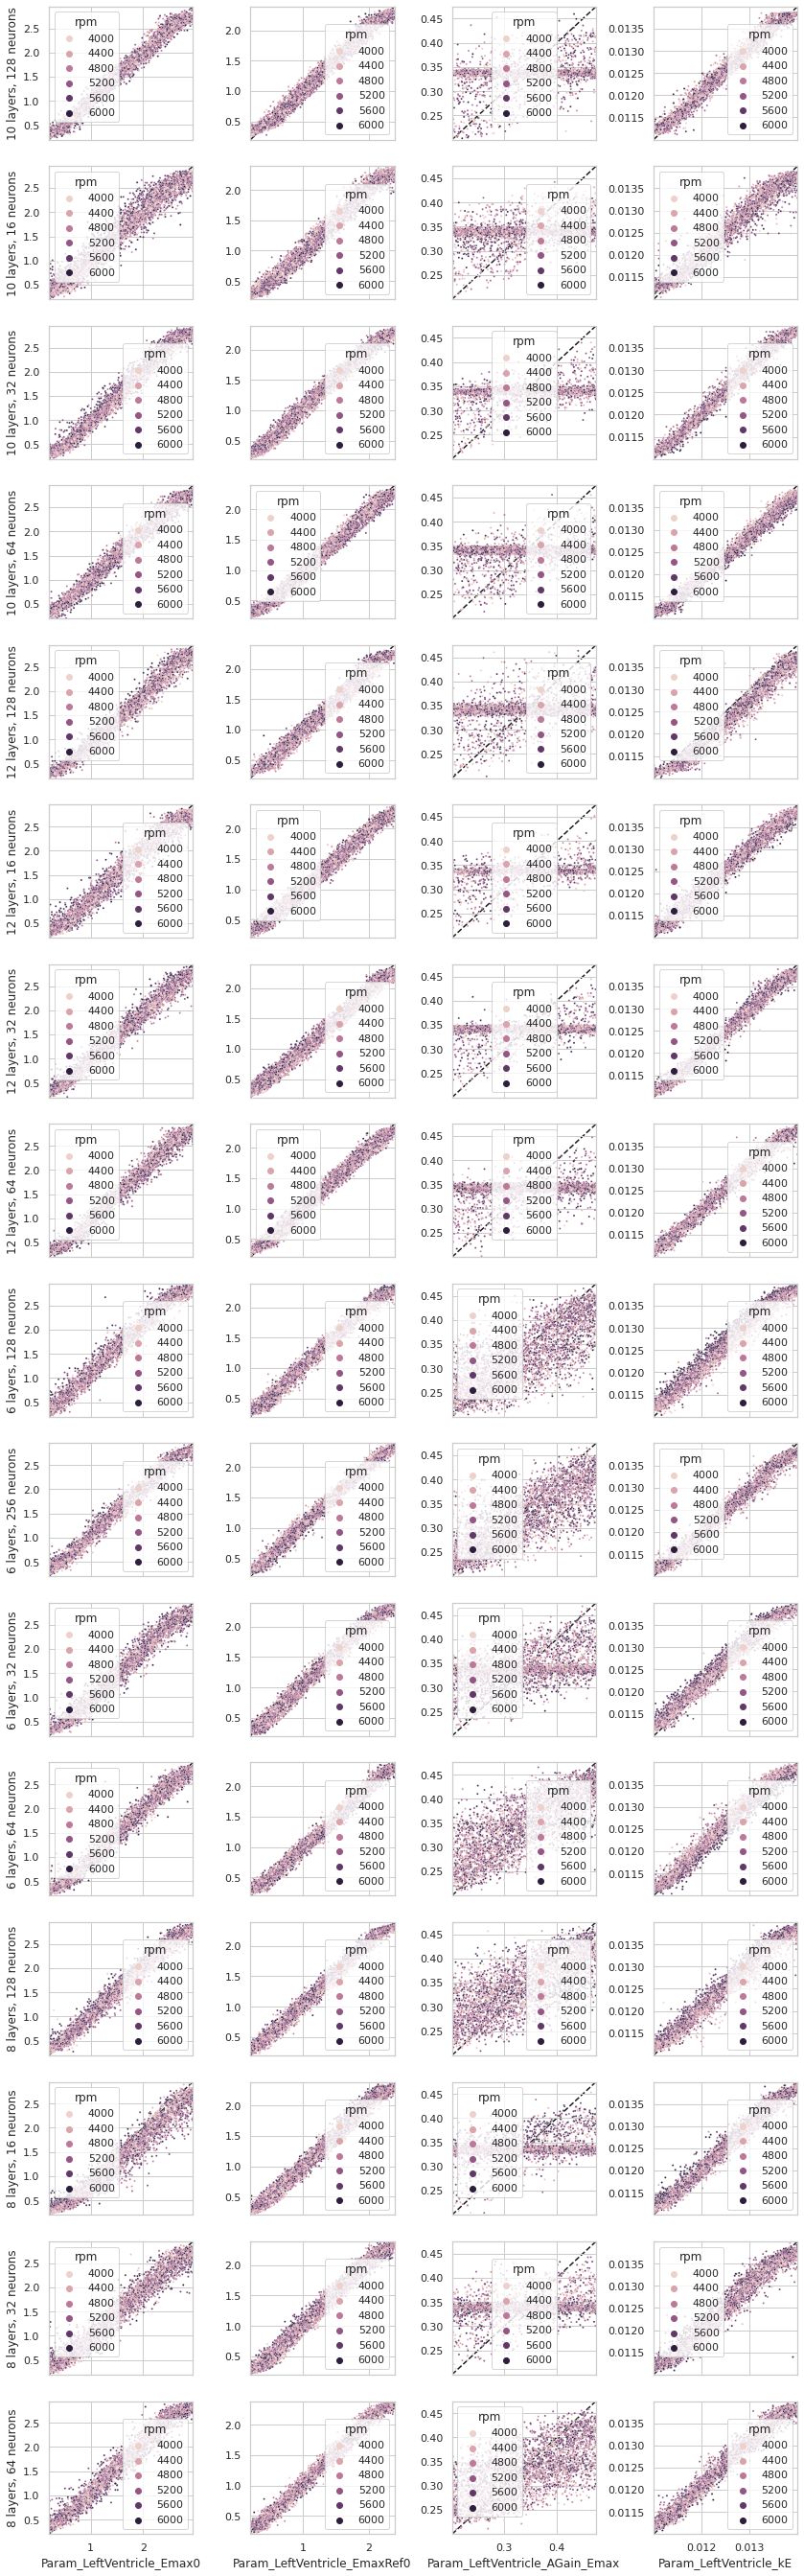

In [28]:
configs = df['desc'].unique()

fig, ax = plt.subplots(len(configs), 4, figsize=(14, len(configs)*3 + .5),
                       sharex='col', sharey='col')
colors = sns.color_palette(n_colors=4)

for i, config in enumerate(configs):
    for j, (var, a) in enumerate(zip(names, ax[i])):
        sns.scatterplot(data=df[df.desc == config].sample(frac=.3), x=var, y=f'{var}_hat', hue='rpm', ax=a, color=colors[j], s=4)
        a.set_ylabel('')
        a.axis(**axes[var])
        a.plot([axes[var]['xmin'],axes[var]['xmax']], [axes[var]['ymin'], axes[var]['ymax']], '--k', zorder=0)

for conf, a in zip(configs, ax[:, 0]):
    a.set_ylabel(conf.replace('_', ' '))
    
plt.subplots_adjust(wspace=.4)
#plt.tight_layout()
plt.savefig('figs/dnn_comparison_rpm.pdf')